# Entries

1. Historical statistics of direct confrontation (team 1 vs team 2)
2. Statistics of *N* previous matches for each team
3. Home player or away player
4. Current points on championship
5. Match day matters?

In [1]:
import sys
sys.path.append("..")

In [2]:
from pprint import pprint
from pymongo import MongoClient
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from db.database import DAO

In [3]:
dao = DAO()
matches_collection = dao.matches()

In [4]:
# Sample match for testing
sample = matches_collection.find_one()
pprint(sample)

{'_id': ObjectId('5ac952926b5b9e2af46c59ef'),
 'arbiter': 'Leonardo Gaciba da Silva',
 'away_team': 'Santos',
 'cards': [{'player': 'Alex Sandro', 'team': 'SAN', 'type': 'yellow'},
           {'player': 'Zé Eduardo', 'team': 'SAN', 'type': 'yellow'},
           {'player': 'Herrera', 'team': 'BOT', 'type': 'yellow'},
           {'player': 'Wesley', 'team': 'SAN', 'type': 'yellow'},
           {'player': 'Alex Sandro', 'team': 'SAN', 'type': 'red'}],
 'coaches': {'away_team': 'Dorival Júnior', 'home_team': 'Joel Santana'},
 'home_team': 'Botafogo',
 'location': {'city': 'Brasil, Rio de Janeiro, RJ', 'stadium': 'Engenhão'},
 'players': {'away_team': [{'name': 'Felipe Garcia', 'position': 'GOL'},
                           {'name': 'Bruno Aguiar', 'position': 'ZAD'},
                           {'name': 'Durval', 'position': 'ZAE'},
                           {'name': 'Maranhão', 'position': 'LAD'},
                           {'name': 'Alex Sandro', 'position': 'LAE'},
                     

## Match Vectorizer
Takes a match in the above format and extracts the most important characteristics in the following order:

<ol>
- Current match statistics
<li> Home team score </li>
<li> Away team score </li>

- Statistics of all confronts of the teams
<li> Goals by home team </li>
<li> Goals by away team </li>
<li> Number of victories of home team </li>
<li> Number o victories of away team </li>
<li> Number of draws </li>

- Statistics of N previous games of each team
<li> Balance of N last games of home team </li>
<li> Balance of N last games of away team </li>
</ol>

In [5]:
# Default match feature extractor. ht is home_team and at is away_team
N = 4
labels = ['ht_score', 'at_score', 'goals_ht', 'goals_at', 'wins_ht', 'wins_at', 'draws', 
          *(['sg_ht']*N), *(['sg_at']*N)]
def vectorize_match(dao, match, N):
    stats = match['statistics']
    score = match['score']
    home_team_last_sg = dao.get_last_N_balances(match['home_team'], N)
    away_team_last_sg = dao.get_last_N_balances(match['away_team'], N)
    return [
            score['home_team'],
            score['away_team'], 
            stats['goals_home_team'], 
            stats['goals_away_team'],
            stats['wins_home_team'], 
            stats['wins_away_team'], 
            stats['previous_draws'], 
            *home_team_last_sg, 
            *away_team_last_sg
           ]

In [6]:
# Vectorize matches from 2016
matches = matches_collection.find({'year':2016})
data = [vectorize_match(dao, match, N) for match in matches]
data = pd.DataFrame(data=data, columns=labels)
data.head()

,ht_score,at_score,goals_ht,goals_at,wins_ht,wins_at,draws,sg_ht,sg_ht,sg_ht,sg_ht,sg_at,sg_at,sg_at,sg_at
0,4,0,50,39,15,8,13,-1,1,1,0,-2,-1,2,0
1,1,0,48,35,16,9,8,-1,0,2,-2,-1,0,-2,-1
2,1,0,92,80,25,19,17,2,-2,0,0,1,1,-2,2
3,1,0,48,62,10,17,12,0,-1,-1,0,0,1,1,1
4,0,1,72,97,21,26,13,-1,1,2,2,1,0,1,0


In [7]:
# Splitting X and Y
Y = data.iloc[:,:2]
X = data.iloc[:,2:]
Y.head() # Y.values to extract the matrix from dataframe

,ht_score,at_score
0,4,0
1,1,0
2,1,0
3,1,0
4,0,1


In [8]:
# Feature Scaling
from sklearn.preprocessing import RobustScaler
xscaler = RobustScaler()
yscaler = RobustScaler()
X = xscaler.fit_transform(X)
Y = yscaler.fit_transform(Y)

### Splitting training and test sets
- Training set size: 80%
- Testing set size: 20%
- Temporal order maintained (random_state=0)

In [9]:
# Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

## Building the Perceptron ANN
- Input layer size: 13 (see match vectorizer for description)
- Output layer size: 2

### Task 1: Train/Test

In [10]:
# Importing libraries
from keras.models import Sequential
from keras.layers import Dense

/home/dcandrade/.anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [408]:
metrics = ['mean_absolute_error', 'binary_accuracy']
log = {}
log_val = {}

In [421]:
# Creating the neural network
loss = 'mse'
opt = 'rmsprop'
init = 'glorot_uniform'
num_hidden = 8
model = Sequential()
model.add(Dense(num_hidden, input_dim=len(X_train[0]), activation='tanh', kernel_initializer=init))
model.add(Dense(2, activation='linear', kernel_initializer=init))

model.compile(loss=loss, optimizer=opt, metrics=metrics)

In [422]:
# # Creating the neural network - BEST MODEL
# metrics = ['mean_absolute_error', 'binary_accuracy']
# model = Sequential()
# model.add(Dense(8, input_dim=len(X_train[0]), activation='tanh'))
# model.add(Dense(2, activation='linear'))

# # model.compile(loss='mse', optimizer='adam', metrics=metrics)

### Statistics for different activation functions
With MSE loss and SGD optimizer


Activation| MAE | Binary accuracy
--- | --- | ---
linear + linear| 65.65 | **46.05**
relu + linear | 76.02 | 46.05
linear + relu | problema min=1|
linear + sigmoid | 66.79 | 40.13
sigmoid | 67.77 | 40.13
sigmoid + relu | 71.32 | 36.18
sigmoid + linear | 67.90 | 42.11
linear + tanh | |
relu + tanh | |

In [423]:
# Training
validation = True
if validation:
    history = model.fit(X_train, Y_train, epochs=300, batch_size=10, verbose=1, validation_split=0.2)
else:
    history = model.fit(X_train, Y_train, epochs=300, batch_size=10, verbose=1)

scores = model.evaluate(X_test, Y_test, verbose=0)

print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("\n%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))

Train on 242 samples, validate on 61 samples
Epoch 1/300
242/242 [==============================] - 1s 4ms/step - loss: 1.5875 - mean_absolute_error: 0.9591 - binary_accuracy: 0.2521 - val_loss: 1.1937 - val_mean_absolute_error: 0.8617 - val_binary_accuracy: 0.2131
Epoch 2/300
242/242 [==============================] - 0s 318us/step - loss: 1.4403 - mean_absolute_error: 0.9122 - binary_accuracy: 0.2624 - val_loss: 1.1075 - val_mean_absolute_error: 0.8250 - val_binary_accuracy: 0.2459
Epoch 3/300
242/242 [==============================] - 0s 334us/step - loss: 1.3340 - mean_absolute_error: 0.8788 - binary_accuracy: 0.2645 - val_loss: 1.0370 - val_mean_absolute_error: 0.7986 - val_binary_accuracy: 0.2705
Epoch 4/300
242/242 [==============================] - 0s 334us/step - loss: 1.2488 - mean_absolute_error: 0.8540 - binary_accuracy: 0.2810 - val_loss: 0.9878 - val_mean_absolute_error: 0.7805 - val_binary_accuracy: 0.2787
Epoch 5/300
242/242 [==============================] - 0s 320us/s

242/242 [==============================] - 0s 327us/step - loss: 0.9031 - mean_absolute_error: 0.7276 - binary_accuracy: 0.3161 - val_loss: 0.8279 - val_mean_absolute_error: 0.7398 - val_binary_accuracy: 0.3033
Epoch 38/300
242/242 [==============================] - 0s 329us/step - loss: 0.9025 - mean_absolute_error: 0.7275 - binary_accuracy: 0.3202 - val_loss: 0.8288 - val_mean_absolute_error: 0.7408 - val_binary_accuracy: 0.3033
Epoch 39/300
242/242 [==============================] - 0s 342us/step - loss: 0.9000 - mean_absolute_error: 0.7260 - binary_accuracy: 0.3202 - val_loss: 0.8290 - val_mean_absolute_error: 0.7410 - val_binary_accuracy: 0.3115
Epoch 40/300
242/242 [==============================] - 0s 336us/step - loss: 0.8986 - mean_absolute_error: 0.7255 - binary_accuracy: 0.3202 - val_loss: 0.8328 - val_mean_absolute_error: 0.7428 - val_binary_accuracy: 0.2951
Epoch 41/300
242/242 [==============================] - 0s 352us/step - loss: 0.8972 - mean_absolute_error: 0.7252 - 

Epoch 74/300
242/242 [==============================] - 0s 363us/step - loss: 0.8609 - mean_absolute_error: 0.7095 - binary_accuracy: 0.3430 - val_loss: 0.8466 - val_mean_absolute_error: 0.7464 - val_binary_accuracy: 0.2787
Epoch 75/300
242/242 [==============================] - 0s 320us/step - loss: 0.8595 - mean_absolute_error: 0.7092 - binary_accuracy: 0.3409 - val_loss: 0.8498 - val_mean_absolute_error: 0.7470 - val_binary_accuracy: 0.2951
Epoch 76/300
242/242 [==============================] - 0s 316us/step - loss: 0.8587 - mean_absolute_error: 0.7093 - binary_accuracy: 0.3347 - val_loss: 0.8500 - val_mean_absolute_error: 0.7470 - val_binary_accuracy: 0.2951
Epoch 77/300
242/242 [==============================] - 0s 310us/step - loss: 0.8582 - mean_absolute_error: 0.7084 - binary_accuracy: 0.3388 - val_loss: 0.8539 - val_mean_absolute_error: 0.7486 - val_binary_accuracy: 0.2869
Epoch 78/300
242/242 [==============================] - 0s 344us/step - loss: 0.8572 - mean_absolute_err

242/242 [==============================] - 0s 310us/step - loss: 0.8260 - mean_absolute_error: 0.6956 - binary_accuracy: 0.3492 - val_loss: 0.8729 - val_mean_absolute_error: 0.7521 - val_binary_accuracy: 0.2705
Epoch 111/300
242/242 [==============================] - 0s 301us/step - loss: 0.8244 - mean_absolute_error: 0.6959 - binary_accuracy: 0.3512 - val_loss: 0.8733 - val_mean_absolute_error: 0.7518 - val_binary_accuracy: 0.2623
Epoch 112/300
242/242 [==============================] - 0s 262us/step - loss: 0.8238 - mean_absolute_error: 0.6948 - binary_accuracy: 0.3492 - val_loss: 0.8747 - val_mean_absolute_error: 0.7523 - val_binary_accuracy: 0.2705
Epoch 113/300
242/242 [==============================] - 0s 334us/step - loss: 0.8227 - mean_absolute_error: 0.6945 - binary_accuracy: 0.3533 - val_loss: 0.8805 - val_mean_absolute_error: 0.7553 - val_binary_accuracy: 0.2623
Epoch 114/300
242/242 [==============================] - 0s 304us/step - loss: 0.8218 - mean_absolute_error: 0.695

242/242 [==============================] - 0s 336us/step - loss: 0.7950 - mean_absolute_error: 0.6852 - binary_accuracy: 0.3471 - val_loss: 0.8963 - val_mean_absolute_error: 0.7565 - val_binary_accuracy: 0.2623
Epoch 147/300
242/242 [==============================] - 0s 310us/step - loss: 0.7938 - mean_absolute_error: 0.6873 - binary_accuracy: 0.3409 - val_loss: 0.9017 - val_mean_absolute_error: 0.7586 - val_binary_accuracy: 0.2541
Epoch 148/300
242/242 [==============================] - 0s 310us/step - loss: 0.7931 - mean_absolute_error: 0.6856 - binary_accuracy: 0.3430 - val_loss: 0.8980 - val_mean_absolute_error: 0.7569 - val_binary_accuracy: 0.2541
Epoch 149/300
242/242 [==============================] - 0s 365us/step - loss: 0.7922 - mean_absolute_error: 0.6854 - binary_accuracy: 0.3430 - val_loss: 0.8983 - val_mean_absolute_error: 0.7572 - val_binary_accuracy: 0.2541
Epoch 150/300
242/242 [==============================] - 0s 368us/step - loss: 0.7922 - mean_absolute_error: 0.684

242/242 [==============================] - 0s 342us/step - loss: 0.7699 - mean_absolute_error: 0.6759 - binary_accuracy: 0.3471 - val_loss: 0.9243 - val_mean_absolute_error: 0.7677 - val_binary_accuracy: 0.2705
Epoch 183/300
242/242 [==============================] - 0s 334us/step - loss: 0.7703 - mean_absolute_error: 0.6764 - binary_accuracy: 0.3471 - val_loss: 0.9277 - val_mean_absolute_error: 0.7691 - val_binary_accuracy: 0.2787
Epoch 184/300
242/242 [==============================] - 0s 323us/step - loss: 0.7693 - mean_absolute_error: 0.6760 - binary_accuracy: 0.3471 - val_loss: 0.9237 - val_mean_absolute_error: 0.7670 - val_binary_accuracy: 0.2705
Epoch 185/300
242/242 [==============================] - 0s 331us/step - loss: 0.7685 - mean_absolute_error: 0.6763 - binary_accuracy: 0.3492 - val_loss: 0.9294 - val_mean_absolute_error: 0.7689 - val_binary_accuracy: 0.2705
Epoch 186/300
242/242 [==============================] - 0s 348us/step - loss: 0.7682 - mean_absolute_error: 0.677

242/242 [==============================] - 0s 343us/step - loss: 0.7499 - mean_absolute_error: 0.6695 - binary_accuracy: 0.3492 - val_loss: 0.9532 - val_mean_absolute_error: 0.7803 - val_binary_accuracy: 0.2705
Epoch 219/300
242/242 [==============================] - 0s 359us/step - loss: 0.7501 - mean_absolute_error: 0.6674 - binary_accuracy: 0.3512 - val_loss: 0.9502 - val_mean_absolute_error: 0.7793 - val_binary_accuracy: 0.2705
Epoch 220/300
242/242 [==============================] - 0s 292us/step - loss: 0.7508 - mean_absolute_error: 0.6676 - binary_accuracy: 0.3533 - val_loss: 0.9558 - val_mean_absolute_error: 0.7817 - val_binary_accuracy: 0.2623
Epoch 221/300
242/242 [==============================] - 0s 300us/step - loss: 0.7493 - mean_absolute_error: 0.6672 - binary_accuracy: 0.3533 - val_loss: 0.9642 - val_mean_absolute_error: 0.7850 - val_binary_accuracy: 0.2623
Epoch 222/300
242/242 [==============================] - 0s 313us/step - loss: 0.7480 - mean_absolute_error: 0.667

242/242 [==============================] - 0s 356us/step - loss: 0.7349 - mean_absolute_error: 0.6612 - binary_accuracy: 0.3533 - val_loss: 0.9681 - val_mean_absolute_error: 0.7882 - val_binary_accuracy: 0.2541
Epoch 255/300
242/242 [==============================] - 0s 327us/step - loss: 0.7340 - mean_absolute_error: 0.6611 - binary_accuracy: 0.3574 - val_loss: 0.9638 - val_mean_absolute_error: 0.7862 - val_binary_accuracy: 0.2705
Epoch 256/300
242/242 [==============================] - 0s 328us/step - loss: 0.7335 - mean_absolute_error: 0.6599 - binary_accuracy: 0.3595 - val_loss: 0.9651 - val_mean_absolute_error: 0.7868 - val_binary_accuracy: 0.2705
Epoch 257/300
242/242 [==============================] - 0s 301us/step - loss: 0.7328 - mean_absolute_error: 0.6601 - binary_accuracy: 0.3554 - val_loss: 0.9671 - val_mean_absolute_error: 0.7872 - val_binary_accuracy: 0.2705
Epoch 258/300
242/242 [==============================] - 0s 320us/step - loss: 0.7325 - mean_absolute_error: 0.659

242/242 [==============================] - 0s 344us/step - loss: 0.7203 - mean_absolute_error: 0.6551 - binary_accuracy: 0.3492 - val_loss: 0.9874 - val_mean_absolute_error: 0.7953 - val_binary_accuracy: 0.2377
Epoch 291/300
242/242 [==============================] - 0s 320us/step - loss: 0.7195 - mean_absolute_error: 0.6546 - binary_accuracy: 0.3574 - val_loss: 0.9898 - val_mean_absolute_error: 0.7972 - val_binary_accuracy: 0.2459
Epoch 292/300
242/242 [==============================] - 0s 324us/step - loss: 0.7189 - mean_absolute_error: 0.6520 - binary_accuracy: 0.3595 - val_loss: 0.9859 - val_mean_absolute_error: 0.7955 - val_binary_accuracy: 0.2377
Epoch 293/300
242/242 [==============================] - 0s 358us/step - loss: 0.7193 - mean_absolute_error: 0.6517 - binary_accuracy: 0.3512 - val_loss: 0.9848 - val_mean_absolute_error: 0.7944 - val_binary_accuracy: 0.2377
Epoch 294/300
242/242 [==============================] - 0s 349us/step - loss: 0.7176 - mean_absolute_error: 0.652

In [424]:
varying_item = opt
for metric in metrics:
    x = log.get(varying_item, [])
    x.append(history.history[metric])
    log[varying_item] = x
    
    if validation:
        x = log_val.get(varying_item, [])
        x.append(history.history['val_'+metric])
        log_val[varying_item] = k
len(log)

3

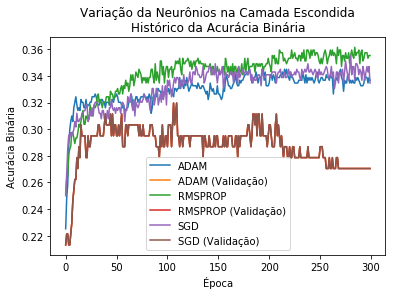

In [425]:
save = True
data_val = {k.upper() + ' (Validação)':log_val[k][1] for k in log_val}
data_ba = {k.upper():log[k][1] for k in log}

data = pd.DataFrame({**data_val, **data_ba})

data.plot()
plt.xlabel('Época')
plt.ylabel('Acurácia Binária')
plt.title('Variação da Neurônios na Camada Escondida\nHistórico da Acurácia Binária')

if save: plt.savefig('../plots/{}_acuracia_binaria.eps'.format(varying_item), format='eps')

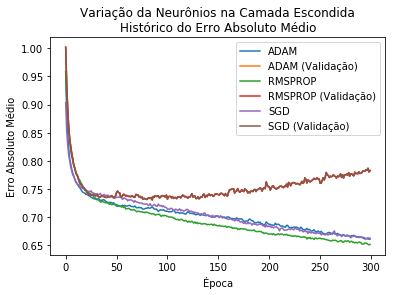

In [426]:
save = True
data_mae = {k.upper() + ' (Validação)':log_val[k][0] for k in log_val}
data_ba = {k.upper():log[k][0] for k in log}

data = pd.DataFrame({**data_mae, **data_ba})
data.plot()
plt.xlabel('Época')
plt.ylabel('Erro Absoluto Médio')
plt.title('Variação da Neurônios na Camada Escondida\nHistórico do Erro Absoluto Médio')
#plt.yscale('log')
if save: plt.savefig('../plots/{}_erro_absoluto_medio.eps'.format(varying_item), format='eps')

In [216]:
evaluation = model.evaluate(X_test, Y_test, verbose=0)
print('Mean absolute error: {}\nBinary accurracy: {}'.format(evaluation[1], evaluation[2]))
k = model.predict(X_test)
yscaler.inverse_transform(k)

Mean absolute error: 0.5865121107352408
Binary accurracy: 0.40789473527356196


array([[0.9943427 , 0.8136172 ],
       [1.9888102 , 0.6401289 ],
       [1.4837811 , 0.9970572 ],
       [1.8115009 , 0.69516   ],
       [2.0017142 , 1.0082201 ],
       [1.4241818 , 0.6837805 ],
       [1.2452106 , 0.4897037 ],
       [1.8309778 , 0.7572093 ],
       [1.953438  , 0.94887686],
       [1.3128315 , 0.92334676],
       [1.7452043 , 0.80007446],
       [1.3448007 , 0.8680996 ],
       [1.4733026 , 1.2118237 ],
       [2.1481347 , 0.69143057],
       [1.2707742 , 1.1576024 ],
       [1.3106017 , 1.3192178 ],
       [1.6540755 , 1.1183404 ],
       [1.3571347 , 1.2015152 ],
       [1.783098  , 0.75032306],
       [1.3752544 , 1.223805  ],
       [1.3761568 , 0.966871  ],
       [1.9451779 , 0.71698177],
       [1.2267709 , 0.6794523 ],
       [1.817841  , 0.6999235 ],
       [2.0909429 , 0.6038416 ],
       [1.6027106 , 0.9232254 ],
       [1.3303483 , 1.0295854 ],
       [1.3864192 , 1.1554074 ],
       [1.5296994 , 0.74367255],
       [1.4428947 , 0.98553044],
       [1.

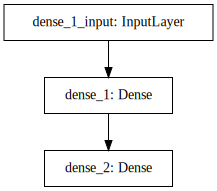

In [20]:
# Network architecture
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))